# Notebook for analysing imaging data (in vitro and ex vivo) 

This use this jupyter notebook for the analysis of your in vitro imaging data (best suited for cell culture data). Before you run this notebook there are a few steps you need to do first:

1. Load your raw imaging tiffs into imagej/fiji
2. Draw the ROIs **IMPORTANT**: Last ROI must be a background ROI 
3. Calculate mean grey value with imagej/fiji 
4. Export your results as csv file



In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import zscore
from sklearn import preprocessing

In [2]:
# Pre processing function:
def pre_processing(df):
    background=df[df.columns[-1]].tolist()  #select background column and make list
    df=df.drop(df.columns[-1], axis=1) #delete last column (background)
    df=df.drop(df.columns[0], axis=1) #delte first column (frame)
    df_background_sub=df.sub(background, axis=0) #subtract background from every other column
    
    return df_background_sub

def dff_calc(df_input,f_base_value=0,dff_median=False):
    
    for column_name in df_input:
        column=df_input[column_name]
        column=column.astype('float')
        if dff_median:
            median_value=column.median()
            dff_series=column.apply((lambda x: (x - median_value)/median_value))
            df_input[column_name]=dff_series
        else:
            dff_series=column.apply((lambda x: (x - column.iloc[f_base_value])/column.iloc[f_base_value])) 
            df_input[column_name]=dff_series
        
    return df_input

## Defining some parameters for your analysis

In the next cell define some parameter:

* Do you want to perform preprocessing (i.e. background substraction) of your imagej/fiji data? 
 * default: `pre_processing_bool=True` <br>
<br>
* Do you want to exclude specific ROIs?         
 * default: `exclude_rois=True` <br>
<br>    
* Do you want to convert frames to seconds? If so input framerate in fps.
 * default: `frames_to_seconds=True` 
 * default: `fps_rate=1` <br>
<br>

**Next**: Input the path to your results csv file from imagej/fiji input the variable: path_to_data

In [3]:
pre_processing_bool=True
frames_to_seconds=True
fps_rate=1.667

path_to_data=r'/Users/lutz/Documents/imaing analysis/exp/mut6'

file_extension='.csv'

if pre_processing_bool==True:
    df=pre_processing(pd.read_csv(path_to_data + file_extension))
else:
    df=pd.read_csv(path_to_data + file_extension)

if frames_to_seconds:
    df.index=df.index/fps_rate
    x_label='Time (s)'
else:
    x_label='Frames'


Before we do anythiny we have to decide if we want to perform detrending (linear oder exponential decay)

Detrending is the process of removing a trend from the data, which can help to correct for any systematic drift or baseline changes in the data over time. This is important because calcium imaging signals can be affected by a variety of factors, such as changes in the illumination of the sample or bleaching of the fluorescent indicator, which can cause a gradual shift in the baseline over time. By removing the trend, the resulting data will have a more consistent baseline, which can improve the accuracy of the calcium event detection algorithm. Here you can see how data with and without bleaching looks like:

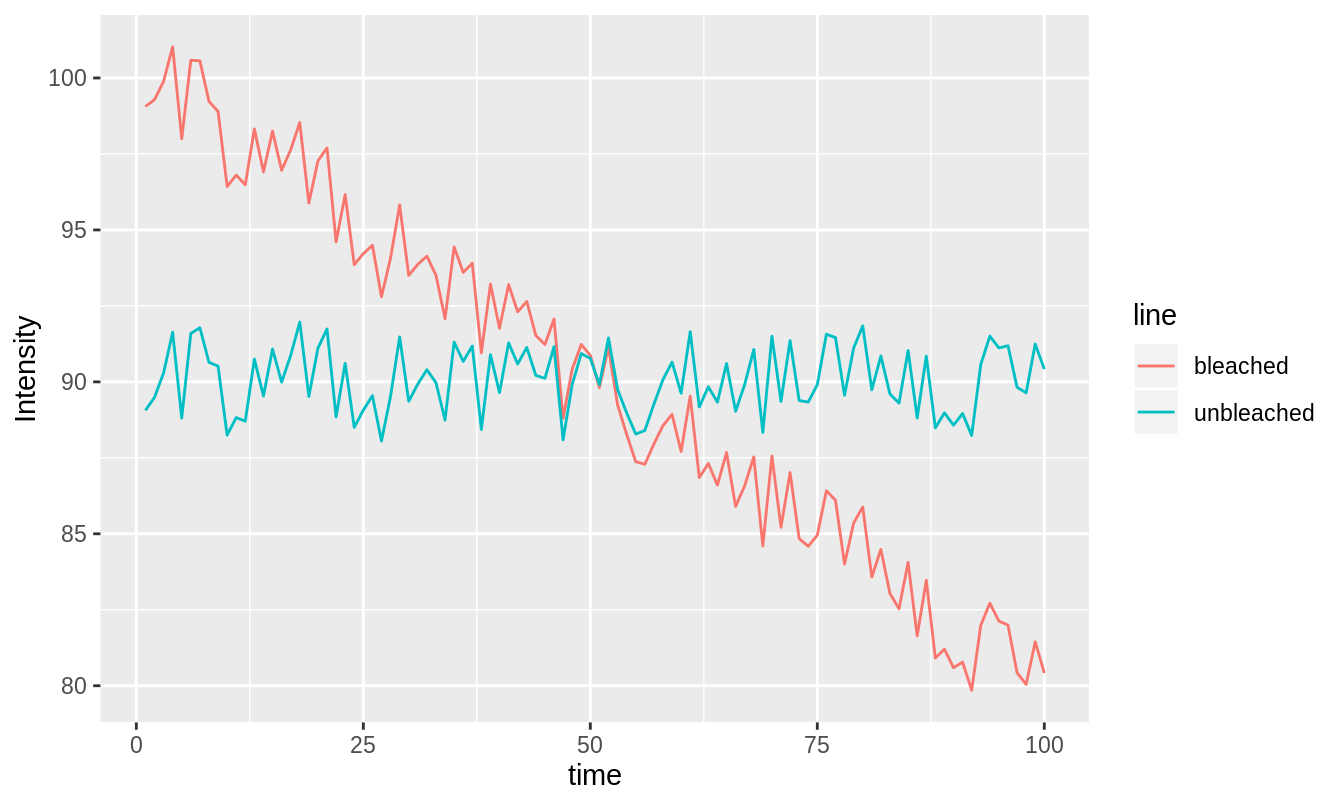

From: https://rorynolan.github.io/phdthesis/photobleaching-correction.html

**Note:** Bleaching is most likely not a purely linear event. It is probably more close to an exponential decay. I have also implemented this in this note. You will be able to chose between linear and exponential decay. You can read more on that at: https://rorynolan.github.io/phdthesis/photobleaching-correction.html  


First you can visualize the individual trials here and decide if you are going to need a detrending.

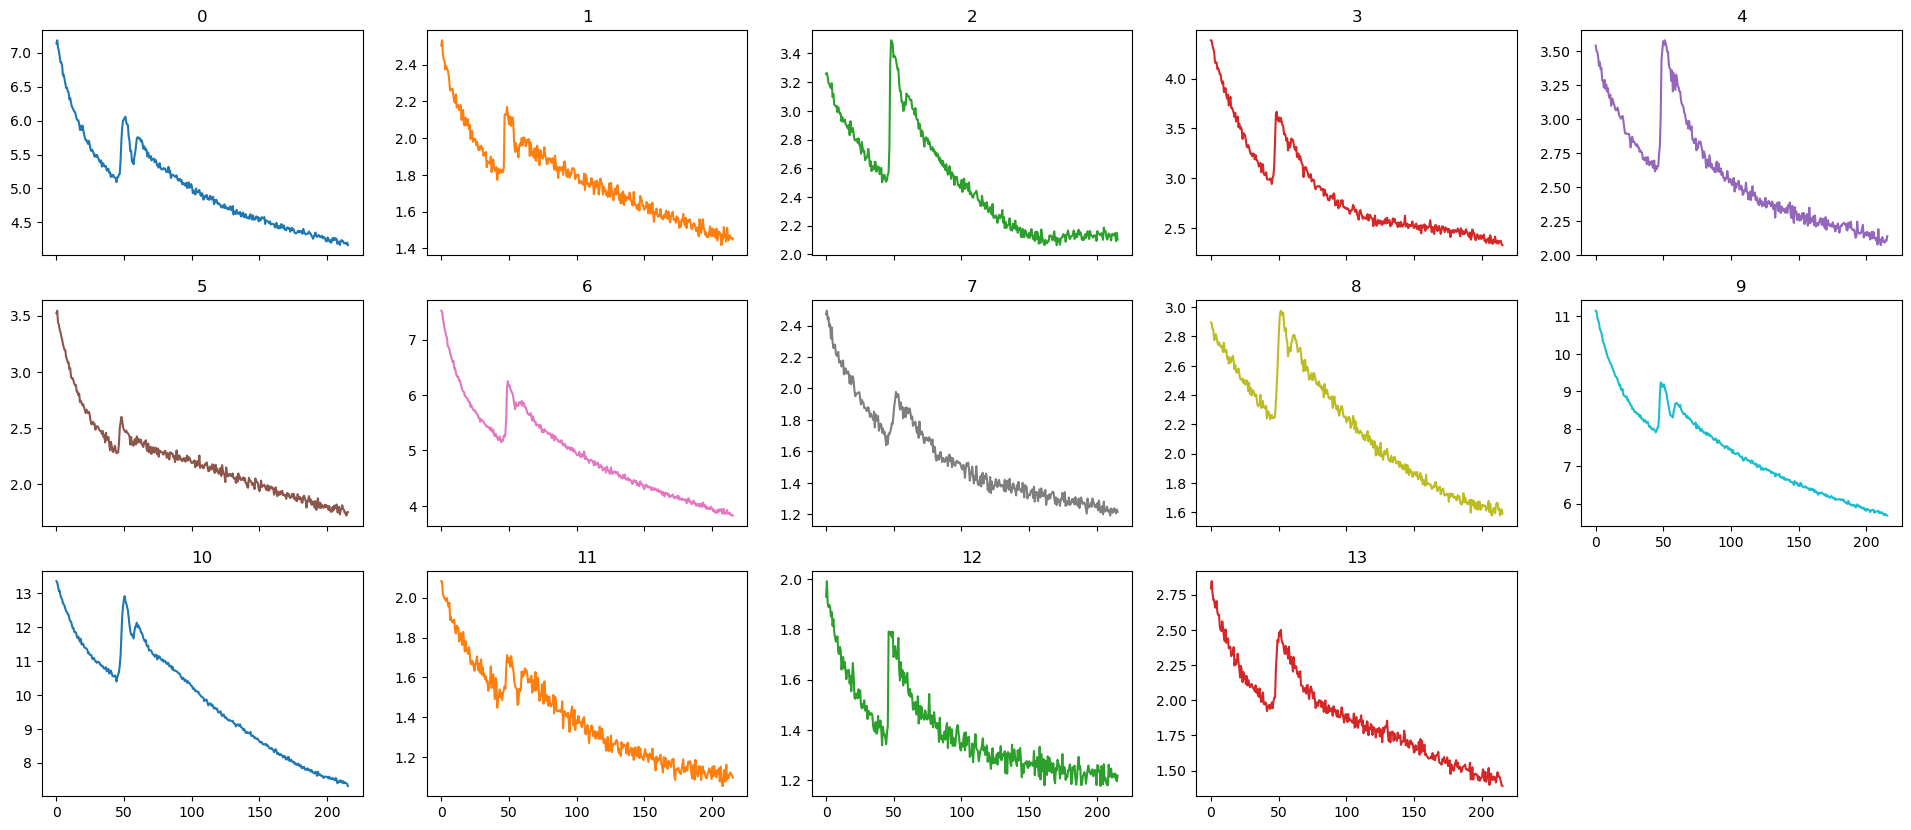

In [4]:
col_num=len(df.columns)
number_of_subplots=list(range(0,len(df.columns)))
axes=df.plot(subplots=True, layout=(7, 5), figsize=(24, 24), sharex=True,sharey=False, legend=None, title=number_of_subplots)

Here you can decide if you want to have detrending or not. This has to be done here because if you chose to do detrending you will NOT calculate $\Delta$f/f

In [5]:
detrend_and_smooth=True

## Calculation of $\Delta$f/f

Now you can calculate $\Delta$f/f but first define the parameters for that: 
* If you want to calculate $\Delta$f/f with the first frame as your f0, you do not need to change anything.
* If you want to calculate $\Delta$f/f with the median fluorescence as your f0, set the parameter `dff_median=True` <br> (i.e. `dff_frame=dff_calc(df_copy, dff_median=True)`)

It also plots each of your ROIs in a subplot and also all ROIs combined
    



In [6]:
if detrend_and_smooth:
    dff_frame=df.copy()
else:
    #df_copy=df.copy()
    dff_frame=dff_calc(df.copy(), dff_median=True)     

In [7]:
  
if not detrend_and_smooth:
    col_num=len(dff_frame.columns)
    number_of_subplots=list(range(0,len(dff_frame.columns)))
    axes=dff_frame.plot(subplots=True, layout=(7, 5), figsize=(24, 24), sharex=True,sharey=True, legend=None, title=number_of_subplots)

    for c in axes:
       for ax in c:
          ax.axhline(y=0, color='k', ls='dashed')

    plt.show()






In [8]:
#plotting individual ROIs in ONE plot (overlayed)
if not detrend_and_smooth:
    dff_frame.plot(legend=None)
    ax = plt.gca()
    ax.axhline(y=0, color='k', ls='dashed')
    plt.xlabel(x_label)
    plt.ylabel('\u0394 F/F')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()

## Excluding ROIs (optional)

If you want exclude some of the ROIs from above set `exclude_rois=True` (default: `exclude_rois=False`) and put the numbers of the ROIs you want to exclude into the list and seperate every ROI by a "," (`list_of_excluded_rois`) below. **IMPORTANT**: Start counting from 0!

It also saves the a new csv file into the current path with the addtion of *_cleaned*

In [9]:
exclude_rois=False
list_of_excluded_rois=[1,4]

if exclude_rois:
    cleaned_df=dff_frame.copy()
    exclude_columns=cleaned_df.iloc[:, list_of_excluded_rois].columns
    cleaned_df=cleaned_df.drop(columns=exclude_columns)    
    cleaned_df.to_csv((path_to_data + '_cleaned' + file_extension), index=False)  
    
    df_mean=cleaned_df.mean(axis=1)
    df_std=cleaned_df.std(axis=1)
    df_sem=cleaned_df.sem(axis=1)
    
else:
    cleaned_df=dff_frame.copy()
    cleaned_df.to_csv((path_to_data + '_cleaned' + file_extension), index=False)
    
    df_mean=dff_frame.mean(axis=1)
    df_std=dff_frame.std(axis=1)
    df_sem=dff_frame.sem(axis=1)

Now plot the ROIs again to make sure you deleted the correct ROIs

In [10]:
#plotting individual ROIs in individual subplots
if exclude_rois:
    
    col_num=len(cleaned_df.columns)
    number_of_subplots=list(range(0,len(cleaned_df.columns)))
    axes=cleaned_df.plot(subplots=True, layout=(7, 5), figsize=(24, 24), sharex=True,sharey=True, legend=None, title=number_of_subplots)

    for c in axes:
       for ax in c:
          ax.axhline(y=0, color='k', ls='dashed')

    plt.show()

    #plotting individual ROIs in ONE plot (overlayed)
    cleaned_df.plot(legend=None)
    ax = plt.gca()
    ax.axhline(y=0, color='k', ls='dashed')
    plt.xlabel(x_label)
    plt.ylabel('\u0394 F/F')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()

## Plotting of the mean time courses

Now you can start plotting the mean of all your ROIs. But first define if you want to save the images (default: `save_images=False`)

In [11]:
start_wash_in=45
end_wash_in=200
save_images=False

In [12]:
if not detrend_and_smooth:
    plt.plot(df_mean, color='black', linewidth=0.75)
    plt.fill_between(df_mean.index, df_mean-df_std, df_mean+df_std, alpha=0.5)
    plt.axvspan(start_wash_in, end_wash_in, color='grey', alpha=0.3, lw=0)

    ax = plt.gca()
    ax.axhline(y=0, color='k', ls='dashed')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel(x_label)
    plt.ylabel('\u0394 F/F')
    plt.title('Mean + SD')
    if save_images:
        plt.savefig((path_to_data[:-4] + '_mean_SD' + '.svg'), format = 'svg', dpi=300) # uncommand this if you want to save it as vector graphic
    plt.show()


In [13]:
start_wash_in=50
end_wash_in=200
save_images=False

In [14]:
if not detrend_and_smooth:
    plt.plot(df_mean, color='black', linewidth=0.75)
    plt.fill_between(df_mean.index, df_mean-df_sem, df_mean+df_sem, alpha=0.5)
    plt.axvspan(start_wash_in, end_wash_in, color='grey', alpha=0.3, lw=0)

    ax = plt.gca()
    ax.axhline(y=0, color='k', ls='dashed')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel(x_label)
    plt.ylabel('\u0394 F/F')
    plt.title('Mean + SEM')
    if save_images:
        plt.savefig((path_to_data[:-4] + '_mean_SEM' + '.svg'), format = 'svg', dpi=300) # uncommand this if you want to save it as vector graphic
    plt.show()

## Analysis of all ROIs from multiple dishes/trials

Now you can start analyzing all ROIs from several dishes or trials together. Just put the path to your new csv files (you calculated and exported them in the previous single dish analysis) into the list `trial_list` in the cell below. Example:

`trial_list=[(pd.read_csv('D:/Lutz imaging/Gq-Pathway Sensor/20210519/Dish1/Analysis/Results_20210519_dish1_new.csv')),
            (pd.read_csv('D:/Lutz imaging/Gq-Pathway Sensor/20210519/Dish3/Analysis/Results_20210519_dish3_new.csv')),
            (pd.read_csv('D:/Lutz imaging/Gq-Pathway Sensor/20210519/Dish4/Analysis/Results_20210519_dish4_new.csv')),
            (pd.read_csv('D:/Lutz imaging/Gq-Pathway Sensor/20210519/Dish5/Analysis/Results_20210519_dish5_new.csv')),
            (pd.read_csv('D:/Lutz imaging/Gq-Pathway Sensor/20210521/Dish1/Analysis/Results_20210521_dish1_new.csv')),
            (pd.read_csv('D:/Lutz imaging/Gq-Pathway Sensor/20210521/Dish3/Analysis/Results_20210521_dish3_new.csv'))
            ]`
            
**IMPORTANT**: The single dish analysis puts an *_cleaned* at the end of your path, so don't forget to include this here.




**IMPORTANT**: If you just want to run multi dish analysis, run the next cell. Otherwise you can ignore it. 

In [15]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [16]:
trial_list=[(pd.read_csv(r'/Users/lutz/Documents/imaing analysis/exp/mut6_cleaned.csv')) 
            ]

col_num=0
for it_count, number in enumerate(trial_list):
    col_num=col_num + len(number.columns)
    number.columns=list(number.columns + '_Trial_' + str(it_count+1))
    
combined_df=pd.concat(trial_list, axis=1) #combine all trials in one dataframe

combined_df.reset_index(drop=True, inplace=True)


**Important**: Because you reseted the DataFrame Index in the cell before, you have to chose again if you want to convert frames into seconds. Also define the `fps_rate`  again

In [17]:
frames_to_seconds=True
fps_rate=1.667

if frames_to_seconds:
    combined_df.index=combined_df.index/fps_rate
    x_label='Time (s)'
else:
    x_label='Frames'

## Optional calculation of $\Delta$f/f

In the single dish/single trial analysis, you saved the data **AFTER** you calculated $\Delta$f/f. Therefore, if you run the notebook completely there is no need to calculated $\Delta$f/f. 

However, there is an option to do it at this point. Just set `run_dff_calc_again=True` (default:`run_dff_calc_again=False`)

Now you can calculate $\Delta$f/f but first define the parameters for that: 
* If you want to calculate $\Delta$f/f with the first frame as your f0, you do not need to change anything.
* If you want to calculate $\Delta$f/f with the median fluorescence as your f0, set the parameter `dff_median=True` <br> (i.e. `dff_frame=dff_calc(df_copy, dff_median=True)`)
    

In [18]:
run_dff_calc_again=False

if run_dff_calc_again:
    combined_df_copy=combined_df.copy()
    dff_combined_df=dff_calc(combined_df_copy, dff_median=True)
else:
    dff_combined_df=combined_df.copy()
    combined_df_mean=dff_combined_df.mean(axis=1)
    combined_df_std=dff_combined_df.std(axis=1)
    combined_df_sem=dff_combined_df.sem(axis=1)

## Ploting of the combined data

Now, that you analysed and combined all data from all trials/dishes into one DataFrame you can start plotting. 


You have some options here:

* Here you have the option to also plot your wash in times (if you have any). Just set `plot_wash_in_1=True` and/or `plot_wash_in_2=True`. Also, if you want to do that, make sure define the timepoints (start and end points).<br> **IMPORTANT**: If you chose the option to convert frames to seconds you also have to set the timepoints as seconds and not as frames.<br>
<br>
* You can also decide to save the plot. Just set `save_images=True` (default: `save_images=False`). Also define the path and the the file name (withou file extension). Example: `path_to_save_date='E:/Lutz imaging/Gq-Pathway Sensor/Plots/KD_mut/Results_20210521_dish3_new'`



**Mean +/- SD**


In [19]:
if not detrend_and_smooth:

    save_images=False
    path_to_save_date=r'E:/Lutz imaging/Gq-Pathway Sensor/Plots/KD_mut/Results_20210521_dish3_new'

    plot_wash_in_1=False

    start_wash_in_1=600 #add start frame of first wash in
    end_wash_in_1=700 #add end frame of first wash in

    if frames_to_seconds:
        start_wash_in_1=start_wash_in_1/fps_rate
        end_wash_in_1=end_wash_in_1/fps_rate


    plot_wash_in_2=False

    start_wash_in_2=1000 #add start frame of second wash in
    end_wash_in_2=1100 #add end frame of second wash in

    if frames_to_seconds:
        start_wash_in_2=start_wash_in_2/fps_rate
        end_wash_in_2=end_wash_in_2/fps_rate

    text_for_fig= 'n=' + str(col_num) + ' cells'

    #plot mean + SD
    plt.figure(figsize=(10,5))
    if plot_wash_in_1:
        plt.axvspan(start_wash_in_1, end_wash_in_1, color='grey', alpha=0.3, lw=0)
    if plot_wash_in_2:
        plt.axvspan(start_wash_in_2, end_wash_in_2, color='grey', alpha=0.3, lw=0)
    plt.plot(combined_df_mean, c='black')
    plt.fill_between(combined_df_mean.index, combined_df_mean-combined_df_std, combined_df_mean+combined_df_std, alpha=0.5)

    ax = plt.gca()
    ax.axhline(y=0, color='k', ls='dashed')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel(x_label)
    plt.ylabel('\u0394 F/F')
    plt.title('Mean + SD')

    plt.text(0.9, 0.9,text_for_fig,
          horizontalalignment='center',
          verticalalignment='center',
          transform = plt.gca().transAxes)
    if save_images:
        plt.savefig((path_to_save_date + 'all_trials_mean_sd.svg'), format='svg', dpi=300)
    plt.show()


Here you can plot **Mean +/- SEM**

In [20]:
if not detrend_and_smooth:

    plt.figure(figsize=(10,5))

    if plot_wash_in_1:
        plt.axvspan(start_wash_in_1, end_wash_in_1, color='grey', alpha=0.3, lw=0)
    if plot_wash_in_2:
        plt.axvspan(start_wash_in_2, end_wash_in_2, color='grey', alpha=0.3, lw=0)

    plt.plot(combined_df_mean, c='black')
    plt.fill_between(combined_df_mean.index, combined_df_mean-combined_df_sem, combined_df_mean+combined_df_sem, alpha=0.5)

    ax = plt.gca()
    ax.axhline(y=0, color='k', ls='dashed')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xlabel(x_label)
    plt.ylabel('\u0394 F/F')
    plt.title('Mean + SEM')
    plt.text(0.9, 0.9,text_for_fig,
          horizontalalignment='center',
          verticalalignment='center',
          transform = plt.gca().transAxes)

    if save_images:
        plt.savefig((path_to_save_date + 'all_trials_mean_sem.svg'), format='svg', dpi=300)
    plt.show()

Here you can plot the **heatmap**

In [21]:
if not detrend_and_smooth:
    if frames_to_seconds:
        mesh_df= combined_df.copy()
        mesh_df.reset_index(drop=True, inplace=True)
        new_index=list(mesh_df.index)
        new_index.append(len(list(mesh_df.index)))
        new_index=pd.Series(new_index)/fps_rate
        new_columns=pd.Series(list(range(0, len(mesh_df.columns)+1)))

        fig, ax0 = plt.subplots(figsize=(10,8))
        im = ax0.pcolormesh(new_index,new_columns, (mesh_df.transpose()))
        fig.colorbar(im, ax=ax0, label='\u0394 F/F')
        ax0.set_xlabel('Time (s)')
        ax0.set_ylabel('ROI Number')   
        if save_images:
            plt.savefig((path_to_save_date + '_heatmap.svg'), format='svg', dpi=300)
        plt.show()


    else:
        fig, ax0 = plt.subplots(figsize=(10,8))
        im = ax0.pcolormesh((combined_df.transpose()))
        fig.colorbar(im, ax=ax0, label='\u0394 F/F')

        ax0.set_xlabel('Frame')
        ax0.set_ylabel('ROI Number')

        ax0.axvline(x=start_wash_in_1, color='k', ls='dashed', alpha=0.75)
        ax0.axvline(x=start_wash_in_2, color='k', ls='dashed', alpha=0.75)
        if save_images:
            plt.savefig((path_to_save_date + '_heatmap.svg'), format='svg', dpi=300)   
        plt.show()

We will start with the smoothing of the data. Smoothing is the process of reducing noise and other unwanted variations in the data by applying a mathematical filter or function to the data. This can help to improve the signal-to-noise ratio of the data, making it easier to detect calcium events that might otherwise be obscured by noise or other artifacts. However, smoothing can also blur the boundaries of calcium events or introduce other artifacts, so it must be carefully applied and validated to ensure that it does not negatively impact the accuracy of the calcium event probability calculation. Here you can see what the smoothing does to data:

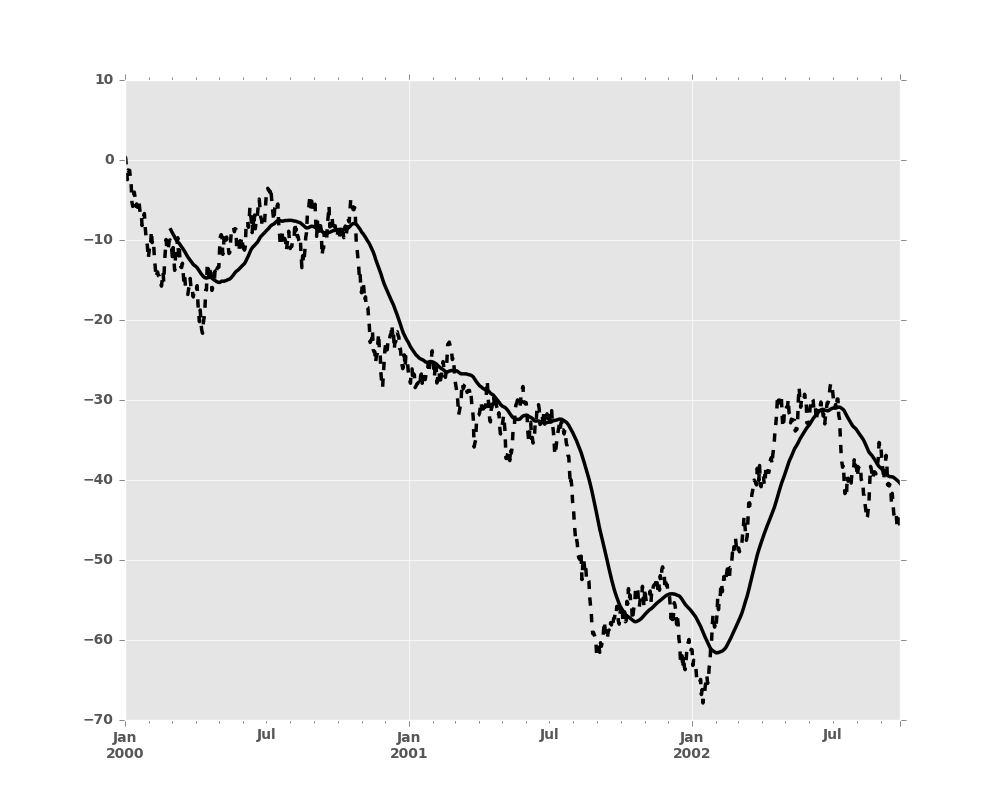

From:https://tedboy.github.io/pandas/computation/computation2.html

The next cells is for you to visualize the smoothing of the data and to find the optimal parameters. You will try out the smoothing on one example trial. You can use the example trial by changing the number stores in the variable  `col_number`.

The two most important parameters are `window_size` and `kernel_std`. The first defines the size of the rolling window that "rolls" over your data and the second one defines how big your gaussian kernel/filter is. Now you might ask, what numbers should I chose? The answer is: You just have to figure it out for your data. That is what the next cell is for. Just play around with the parameters and try to find a combination the filters out the noise but keeps the overal structure of your data.


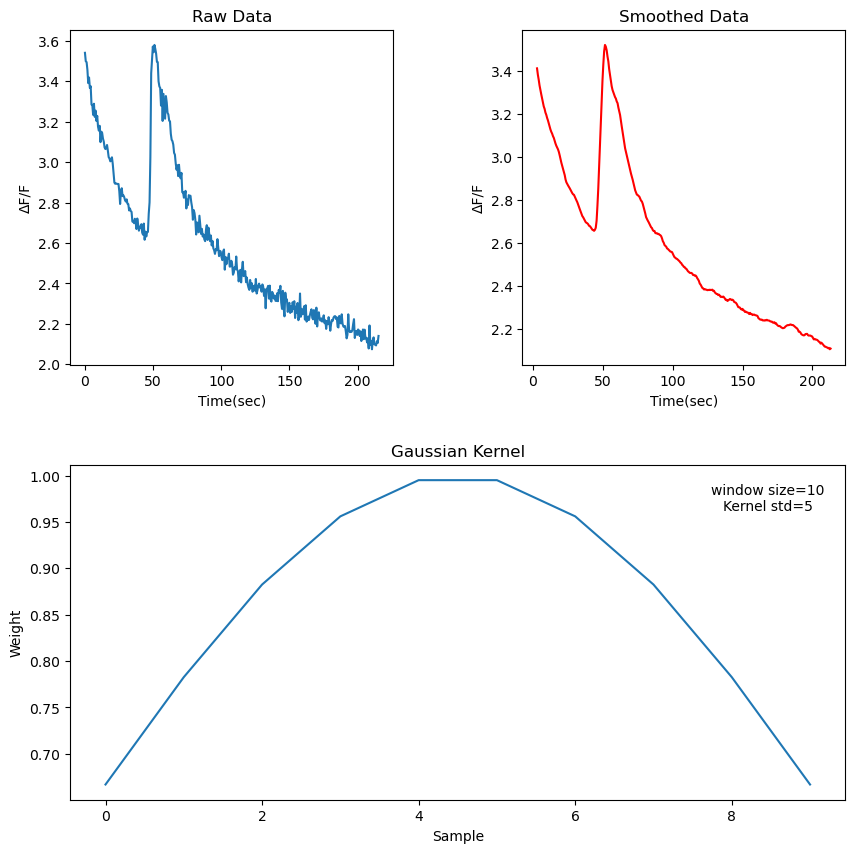

In [22]:
window_size=10
kernel_std=5

col_number=4
cleaned_df=combined_df.copy()
column_name=cleaned_df.columns[col_number]

series_smoothed=cleaned_df[column_name].rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)
series_not_smoothed=cleaned_df[column_name]
window=signal.gaussian(M=window_size, std=kernel_std)


grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, 0])
plt.plot(series_not_smoothed)
ax_1=plt.gca()
ax_1.set_title('Raw Data')
ax_1.set_xlabel('Time(sec)')
ax_1.set_ylabel('\u0394F/F')

plt.subplot(grid[0, 1])
plt.plot(series_smoothed, color='red') 
ax_2=plt.gca()
ax_2.set_title('Smoothed Data')
ax_2.set_xlabel('Time(sec)')
ax_2.set_ylabel('\u0394F/F')

plt.subplot(grid[1, :2])
plt.plot(window)
ax_3=plt.gca()
ax_3.set_title('Gaussian Kernel')
ax_3.set_xlabel('Sample')
ax_3.set_ylabel('Weight')
ax_3.text(0.9,0.9,'window size='+str(window_size)+'\nKernel std='+str(kernel_std),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax_3.transAxes)

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

The next cells is for you to visualize the smoothing **and** the detrending of the data. You will try out the smoothing on one example trial. You can use the example trial by changing the number stores in the variable  `col_number`. First you need to put in your desired `windows_size` and `kernel_std`. After the smoothing, the detrending is performed. Here you do not have to change any parameters. Just decide if you are going to need a linear detrending or not.

Now you have to make a decision if you need to detrend the data. A first step is to visualize ALL cells from all trials. Here you can play around wiht the parameter `figsize=(24, 48)`.

**Note:** Bleaching is most likely not a purely linear event. It is probably more close to an exponential decay. I have also implemented this in this note. You will be able to chose between linear and exponential decay. You can read more on that at: https://rorynolan.github.io/phdthesis/photobleaching-correction.html  


First you can visualize the individual trials here and decide if you are going to use linear or exponential decay detrending.

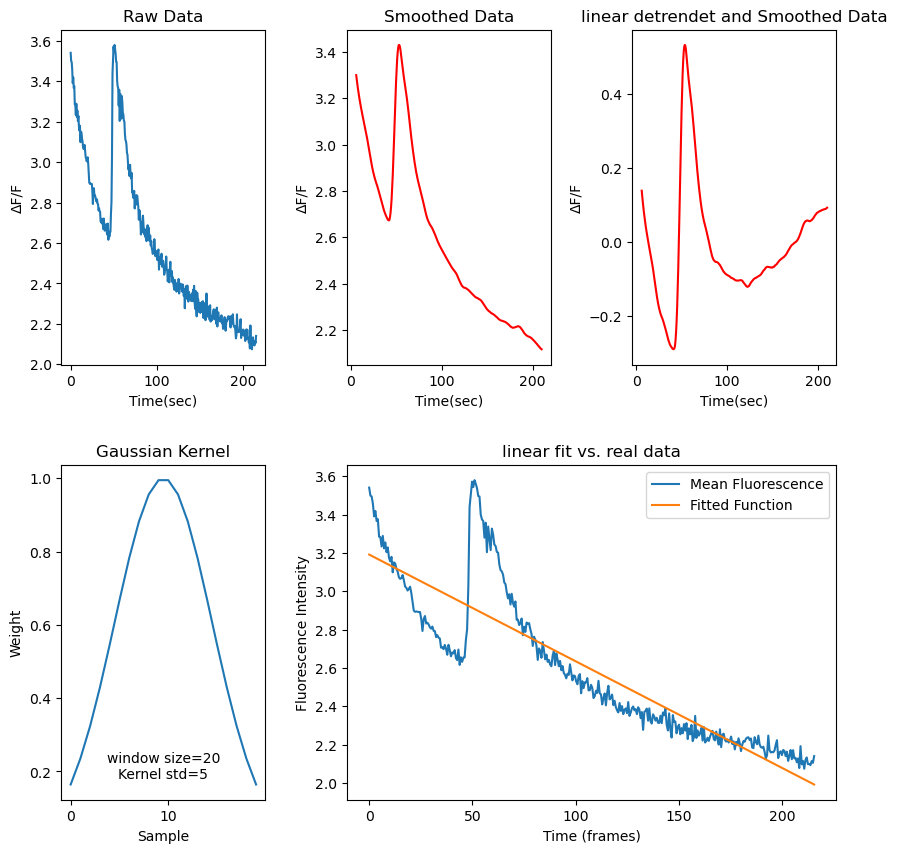

In [23]:
window_size=20
kernel_std=5

col_number=4
column_name=cleaned_df.columns[col_number]

raw_series=cleaned_df[column_name]
series_smoothed=cleaned_df[column_name].rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)

input_array=cleaned_df[column_name].to_numpy()
series_detrend_1=signal.detrend(input_array)
series_detrend=pd.Series(series_detrend_1)
series_detrend=series_detrend.rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)

x = np.arange(len(raw_series))
coef = np.polyfit(x, raw_series, deg=1)
fit = np.polyval(coef, x)

#series_not_smoothed= cleaned_df[column_name].rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)
window=signal.gaussian(M=window_size, std=kernel_std)


grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, 0])
plt.plot(raw_series)
ax_1=plt.gca()
ax_1.set_title('Raw Data')
ax_1.set_xlabel('Time(sec)')
ax_1.set_ylabel('\u0394F/F')

plt.subplot(grid[0, 1])
plt.plot(series_smoothed, color='red') 
ax_2=plt.gca()
ax_2.set_title('Smoothed Data')
ax_2.set_xlabel('Time(sec)')
ax_2.set_ylabel('\u0394F/F')

series_detrend.index=series_detrend.index/fps_rate
plt.subplot(grid[0, 2])
plt.plot(series_detrend, color='red') 
ax_2=plt.gca()
ax_2.set_title('linear detrendet and Smoothed Data')
ax_2.set_xlabel('Time(sec)')
ax_2.set_ylabel('\u0394F/F')

plt.subplot(grid[1, 0])
plt.plot(window)
ax_3=plt.gca()
ax_3.set_title('Gaussian Kernel')
ax_3.set_xlabel('Sample')
ax_3.set_ylabel('Weight')
ax_3.text(0.5,0.1,'window size='+str(window_size)+'\nKernel std='+str(kernel_std),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax_3.transAxes)

fit=pd.Series(fit)
fit.index=fit.index/fps_rate
plt.subplot(grid[1, 1:])
plt.plot(raw_series, label='Mean Fluorescence')
plt.plot(fit, label='Fitted Function')
ax_4=plt.gca()
ax_4.set_xlabel('Time (frames)')
ax_4.set_ylabel('Fluorescence Intensity')
ax_4.legend()
ax_4.set_title('linear fit vs. real data')

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()



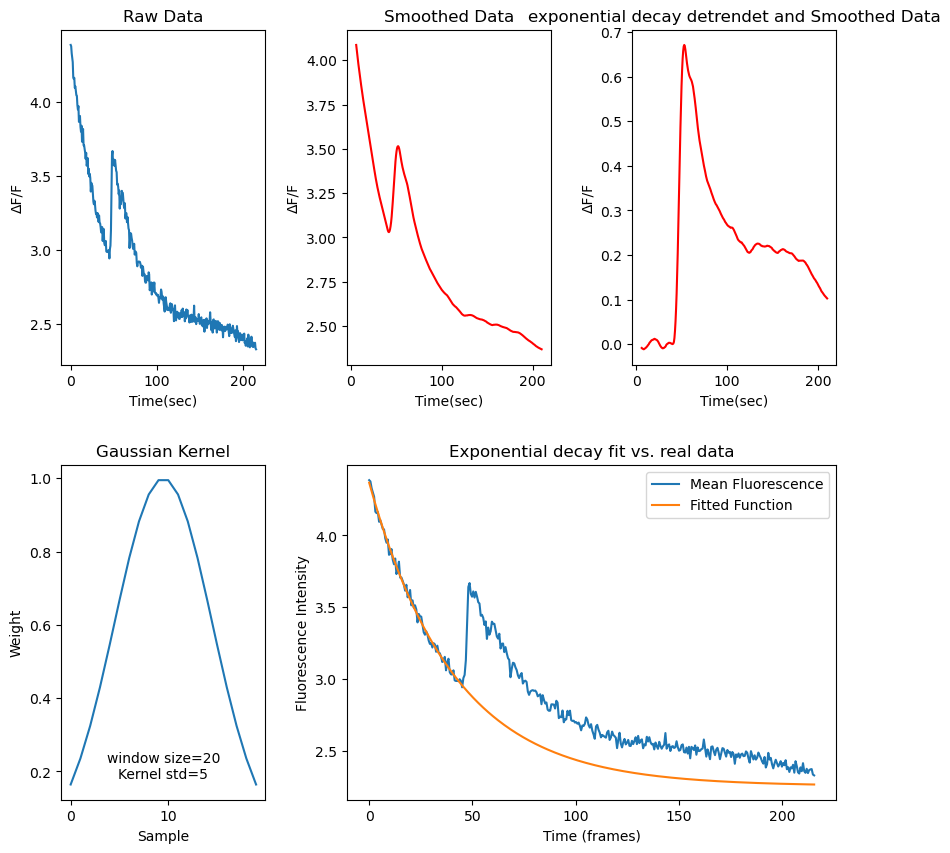

In [24]:
window_size=20
kernel_std=5
detrending_on_baseline=True
base_line_end_time=45

col_number=3
column_name=cleaned_df.columns[col_number]

raw_series=cleaned_df[column_name]
series_smoothed=cleaned_df[column_name].rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)

if detrending_on_baseline:
    avg_fluorescence = cleaned_df[column_name][:base_line_end_time]
    #avg_fluorescence = cleaned_df[:base_line_end_time].mean(axis=1)
else:
    avg_fluorescence = cleaned_df[column_name]#.mean(axis=1)
    
#avg_fluorescence = cleaned_df[:base_line_end_time].mean(axis=1)

# Define the exponential decay function
def decay_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit the exponential decay function to the average fluorescence signal
x = np.arange(len(avg_fluorescence))
popt, pcov = curve_fit(decay_func, x, avg_fluorescence)

# Use the fitted decay function to detrend the fluorescence signal for each ROI
df_detrend = cleaned_df.apply(lambda x: x - decay_func(np.arange(len(x)), *popt), axis=0)
series_detrend=df_detrend[column_name]
series_detrend=series_detrend.rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)


window=signal.gaussian(M=window_size, std=kernel_std)


grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, 0])
plt.plot(raw_series)
ax_1=plt.gca()
ax_1.set_title('Raw Data')
ax_1.set_xlabel('Time(sec)')
ax_1.set_ylabel('\u0394F/F')

plt.subplot(grid[0, 1])
plt.plot(series_smoothed, color='red') 
ax_2=plt.gca()
ax_2.set_title('Smoothed Data')
ax_2.set_xlabel('Time(sec)')
ax_2.set_ylabel('\u0394F/F')

plt.subplot(grid[0, 2])
plt.plot(series_detrend, color='red') 
ax_2=plt.gca()
ax_2.set_title('exponential decay detrendet and Smoothed Data')
ax_2.set_xlabel('Time(sec)')
ax_2.set_ylabel('\u0394F/F')

plt.subplot(grid[1, 0])
plt.plot(window)
ax_3=plt.gca()
ax_3.set_title('Gaussian Kernel')
ax_3.set_xlabel('Sample')
ax_3.set_ylabel('Weight')
ax_3.text(0.5,0.1,'window size='+str(window_size)+'\nKernel std='+str(kernel_std),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax_3.transAxes)

if detrending_on_baseline:
    avg_fluorescence = cleaned_df[column_name]#[:base_line_end_time]
    x = np.arange(len(avg_fluorescence))
    
avg=pd.Series(avg_fluorescence)
#avg.index=avg.index/fps_rate
decay_fit=pd.Series(decay_func(x, *popt))
decay_fit.index=decay_fit.index/fps_rate

plt.subplot(grid[1, 1:])
#plt.plot(x, avg_fluorescence, label='Mean Fluorescence')
#plt.plot(x, decay_func(x, *popt), label='Fitted Function')
plt.plot(avg, label='Mean Fluorescence')
plt.plot(decay_fit, label='Fitted Function')
ax_4=plt.gca()
ax_4.set_xlabel('Time (frames)')
ax_4.set_ylabel('Fluorescence Intensity')
ax_4.legend()
ax_4.set_title('Exponential decay fit vs. real data')

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

In [25]:
gaussian_smoothing=True
detrending_method='exp_decay' #or 'exp_decay' or 'no_detrending'
detrending_on_baseline=True
base_line_end_time=45

In [26]:
   
    if gaussian_smoothing:
                    
        if detrending_method=='linear':
            def lin_det(x):
                input_series=x.to_numpy()
                detrend_series=signal.detrend(input_series)
                detrend_series=pd.Series(detrend_series)
                detrend_series=detrend_series.rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)
                return detrend_series
            detrend_df=cleaned_df.apply(lambda x: lin_det(x))
                            
        elif detrending_method=='exp_decay':
            def exp_decay(column):
                avg_fluorescence =column[:base_line_end_time]
                x = np.arange(len(avg_fluorescence))
                def decay_func(x, a, b, c):
                    return a * np.exp(-b * x) + c
                popt, pcov = curve_fit(decay_func, x, avg_fluorescence)
                series=column - decay_func(np.arange(len(column)), *popt)
                series=series.rolling(window=window_size, win_type='gaussian', center=True, axis=0).mean(std=kernel_std)
                return series
            
            detrend_df=cleaned_df.apply(lambda x: exp_decay(x))
            
            
        elif detrending_method=='no_detrending':
            detrend_df=cleaned_df.rolling(window=window_size, win_type='gaussian', center=True).mean(std=kernel_std)
    else:
        
        if linear_detrending:
            def lin_det(x):
                input_series=x.to_numpy()
                detrend_series=signal.detrend(input_series)
                detrend_series=pd.Series(detrend_series)
                return detrend_series
            detrend_df=cleand_df.apply(lambda x: lin_det(x))
                            
        elif exp_decay:
            detrend_list=[]
            for i in trial_list:
                avg_fluorescence = i.mean(axis=1)
                x = np.arange(len(avg_fluorescence))
                def decay_func(x, a, b, c):
                    return a * np.exp(-b * x) + c
                # Fit the exponential decay function to the average fluorescence signal
                popt, pcov = curve_fit(decay_func, x, avg_fluorescence)
                detrend_df=i.apply(lambda x: x - decay_func(np.arange(len(x)), *popt), axis=0)
                detrend_list.append(detrend_df)                      

            detrend_df=pd.concat(detrend_list, axis=1)
        elif detrending_method=='no_detrending':
            detrend_df=cleaned_df

The code defines a function called df_norma, which takes two inputs:

* df: A pandas DataFrame containing your data.
* normalization_method: The method used to normalize the data. It has a default value of 'max_abs', but you can choose between 'zscore', 'min-max', and 'max_abs'.

Here's what each normalization method does:

* 'zscore': It scales the data using the Z-score normalization, which means that it subtracts the mean and divides by the standard deviation for each column. This method is useful when you want to compare data with different means and standard deviations.
* min-max': It scales the data to a range of 0 to 1. It subtracts the minimum value and divides by the range (max - min) for each column. This method is useful when you want to bring all values within a specific range.
* 'max_abs': It scales the data by dividing each value by the maximum absolute value in each column. This method is useful when you have positive and negative values, and you want to preserve their signs while scaling them to a range of -1 to 1.

In [27]:
def df_norma(df, normalization_method='max_abs'):
    normalized_df=df.copy()
    
        
    if normalization_method=='zscore':
        normalized_df=normalized_df.apply(lambda x: zscore(x, nan_policy='omit'))
    
    elif normalization_method=='min-max':
        normalized_df= pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(normalized_df),
                                    columns=normalized_df.columns, index=normalized_df.index)
        
    elif normalization_method=='max_abs':
        normalized_df = pd.DataFrame(preprocessing.MaxAbsScaler().fit_transform(normalized_df),
                                  columns=normalized_df.columns, index=normalized_df.index)
        
            
    axes=normalized_df.plot(subplots=True, layout=(7, 5), figsize=(24, 24), sharex=True,sharey=True, legend=None)
    for c in axes:
       for ax in c:
          ax.axhline(y=0, color='k', ls='dashed')

    plt.show()
    return normalized_df

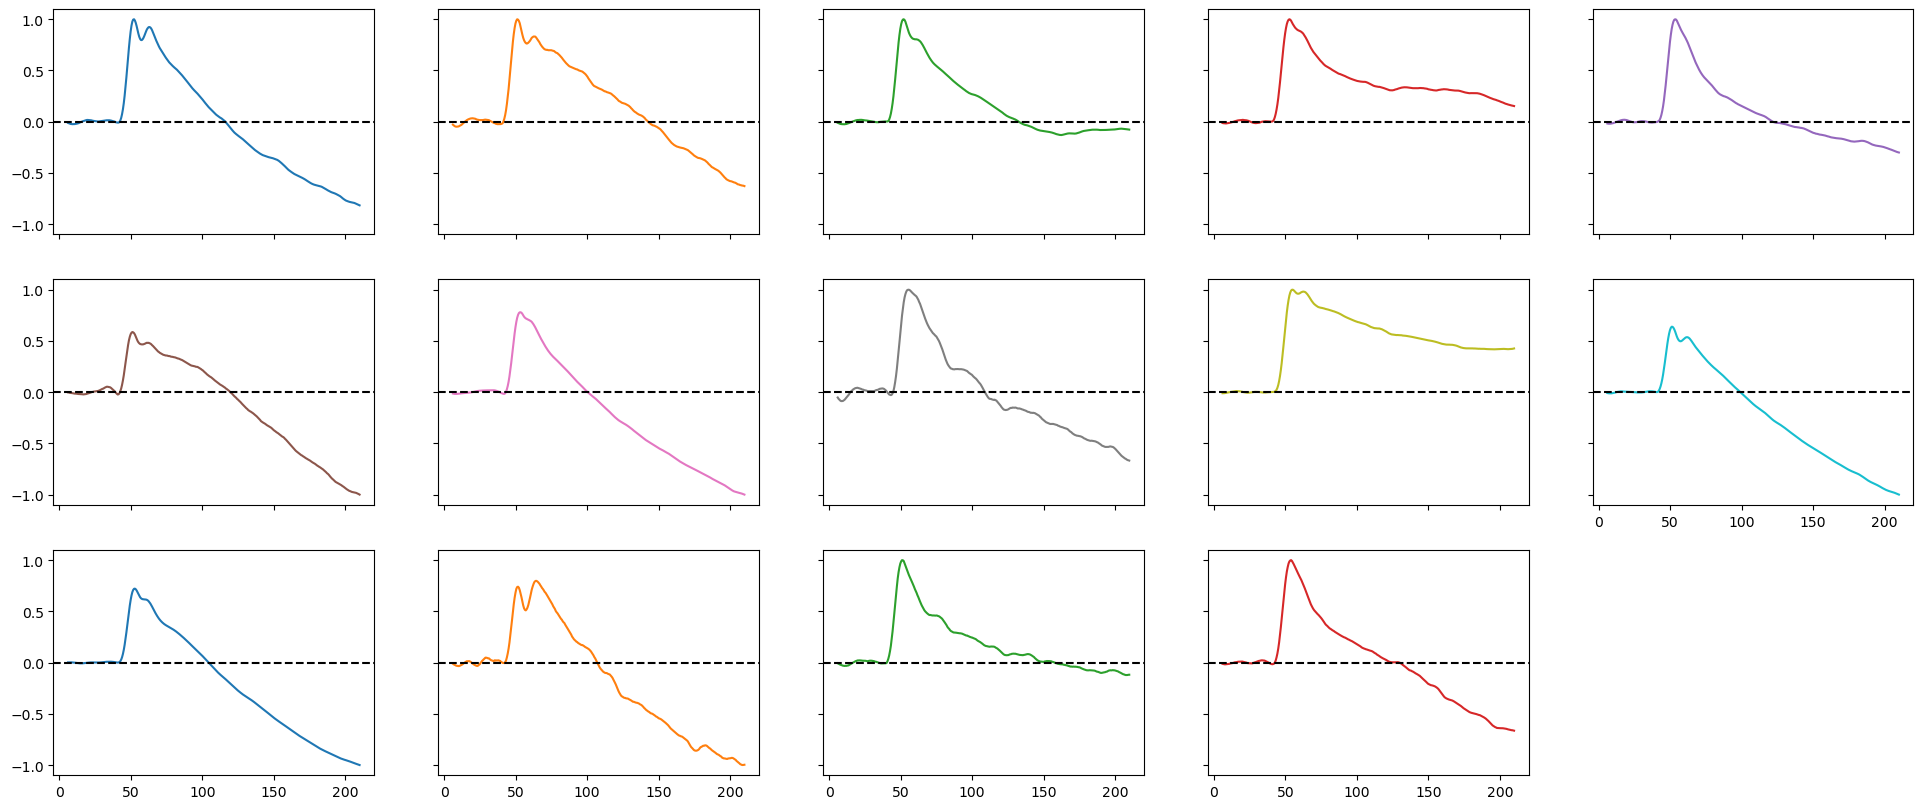

In [28]:
normalized_df=df_norma(detrend_df,normalization_method='max_abs')

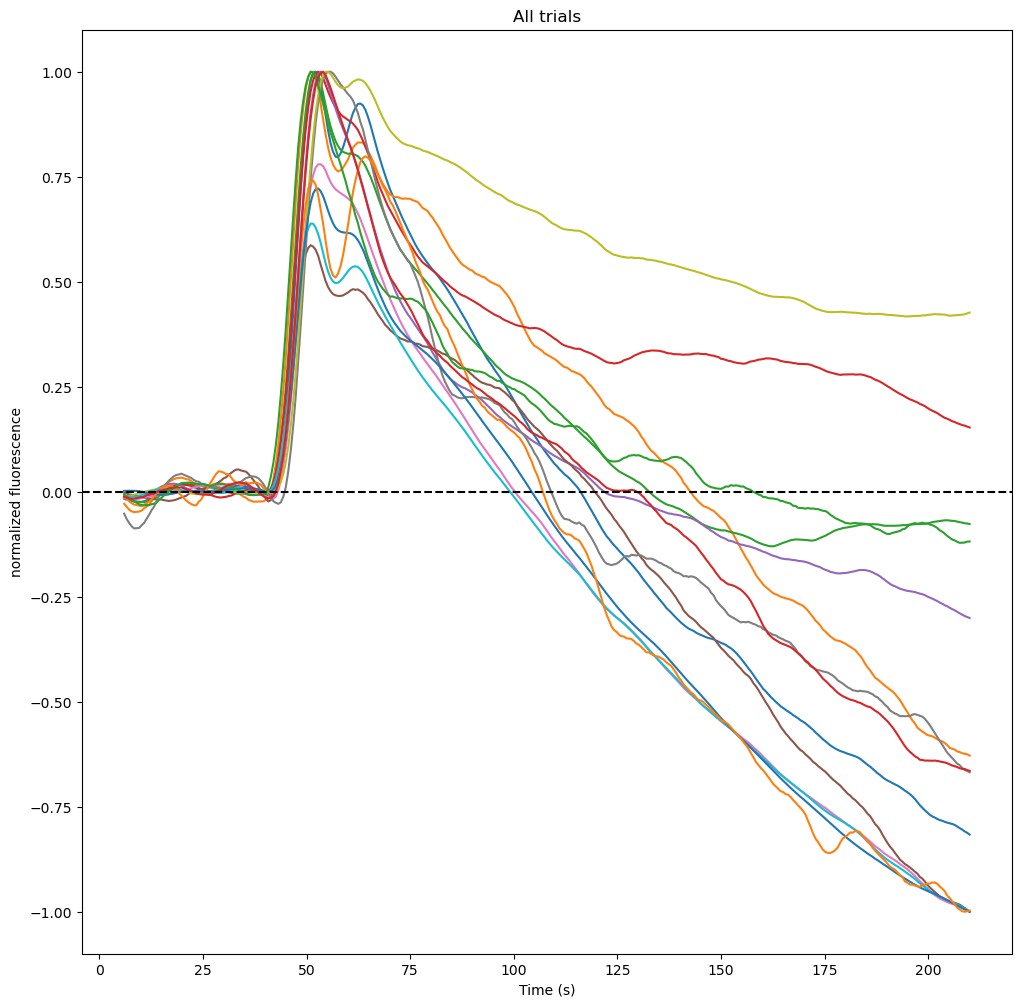

In [29]:
ax=normalized_df.plot(  figsize=(12, 12), legend=None)
ax.axhline(y=0, color='k', ls='dashed')
plt.xlabel('Time (s)')
plt.ylabel('normalized fluorescence')
plt.title('All trials')
plt.show()

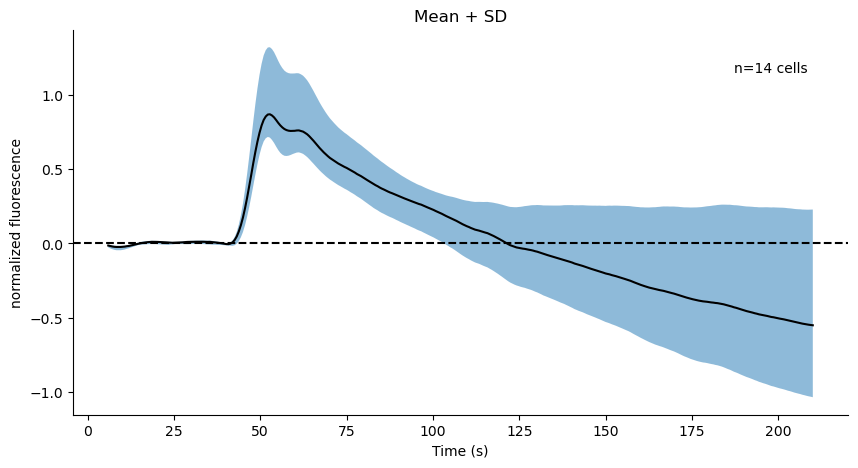

In [30]:


    save_images=False
    path_to_save_date=r'E:/Lutz imaging/Gq-Pathway Sensor/Plots/KD_mut/Results_20210521_dish3_new'

    plot_wash_in_1=False

    start_wash_in_1=600 #add start frame of first wash in
    end_wash_in_1=700 #add end frame of first wash in

    if frames_to_seconds:
        start_wash_in_1=start_wash_in_1/fps_rate
        end_wash_in_1=end_wash_in_1/fps_rate


    plot_wash_in_2=False

    start_wash_in_2=1000 #add start frame of second wash in
    end_wash_in_2=1100 #add end frame of second wash in

    if frames_to_seconds:
        start_wash_in_2=start_wash_in_2/fps_rate
        end_wash_in_2=end_wash_in_2/fps_rate

    text_for_fig= 'n=' + str(col_num) + ' cells'

    #plot mean + SD
    plt.figure(figsize=(10,5))
    if plot_wash_in_1:
        plt.axvspan(start_wash_in_1, end_wash_in_1, color='grey', alpha=0.3, lw=0)
    if plot_wash_in_2:
        plt.axvspan(start_wash_in_2, end_wash_in_2, color='grey', alpha=0.3, lw=0)
    plt.plot(normalized_df.mean(axis=1), c='black')
    plt.fill_between(normalized_df.index, normalized_df.mean(axis=1)-normalized_df.std(axis=1),
                     normalized_df.mean(axis=1)+detrend_df.std(axis=1), alpha=0.5)

    ax = plt.gca()
    ax.axhline(y=0, color='k', ls='dashed')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel(x_label)
    plt.ylabel('normalized fluorescence')
    plt.title('Mean + SD')

    plt.text(0.9, 0.9,text_for_fig,
          horizontalalignment='center',
          verticalalignment='center',
          transform = plt.gca().transAxes)
    if save_images:
        plt.savefig((path_to_save_date + 'all_trials_mean_sd.svg'), format='svg', dpi=300)
    plt.show()


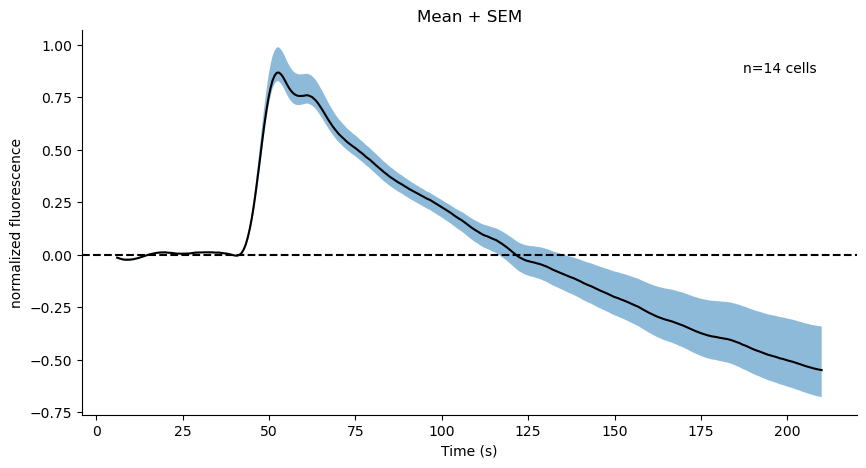

In [31]:


    save_images=False
    path_to_save_date=r'E:/Lutz imaging/Gq-Pathway Sensor/Plots/KD_mut/Results_20210521_dish3_new'

    plot_wash_in_1=False

    start_wash_in_1=600 #add start frame of first wash in
    end_wash_in_1=700 #add end frame of first wash in

    if frames_to_seconds:
        start_wash_in_1=start_wash_in_1/fps_rate
        end_wash_in_1=end_wash_in_1/fps_rate


    plot_wash_in_2=False

    start_wash_in_2=1000 #add start frame of second wash in
    end_wash_in_2=1100 #add end frame of second wash in

    if frames_to_seconds:
        start_wash_in_2=start_wash_in_2/fps_rate
        end_wash_in_2=end_wash_in_2/fps_rate

    text_for_fig= 'n=' + str(col_num) + ' cells'

    #plot mean + SD
    plt.figure(figsize=(10,5))
    if plot_wash_in_1:
        plt.axvspan(start_wash_in_1, end_wash_in_1, color='grey', alpha=0.3, lw=0)
    if plot_wash_in_2:
        plt.axvspan(start_wash_in_2, end_wash_in_2, color='grey', alpha=0.3, lw=0)
    plt.plot(normalized_df.mean(axis=1), c='black')
    plt.fill_between(normalized_df.index, normalized_df.mean(axis=1)-normalized_df.sem(axis=1),
                     normalized_df.mean(axis=1)+detrend_df.sem(axis=1), alpha=0.5)

    ax = plt.gca()
    ax.axhline(y=0, color='k', ls='dashed')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel(x_label)
    plt.ylabel('normalized fluorescence')
    plt.title('Mean + SEM')

    plt.text(0.9, 0.9,text_for_fig,
          horizontalalignment='center',
          verticalalignment='center',
          transform = plt.gca().transAxes)
    if save_images:
        plt.savefig((path_to_save_date + 'all_trials_mean_sd.svg'), format='svg', dpi=300)
    plt.show()


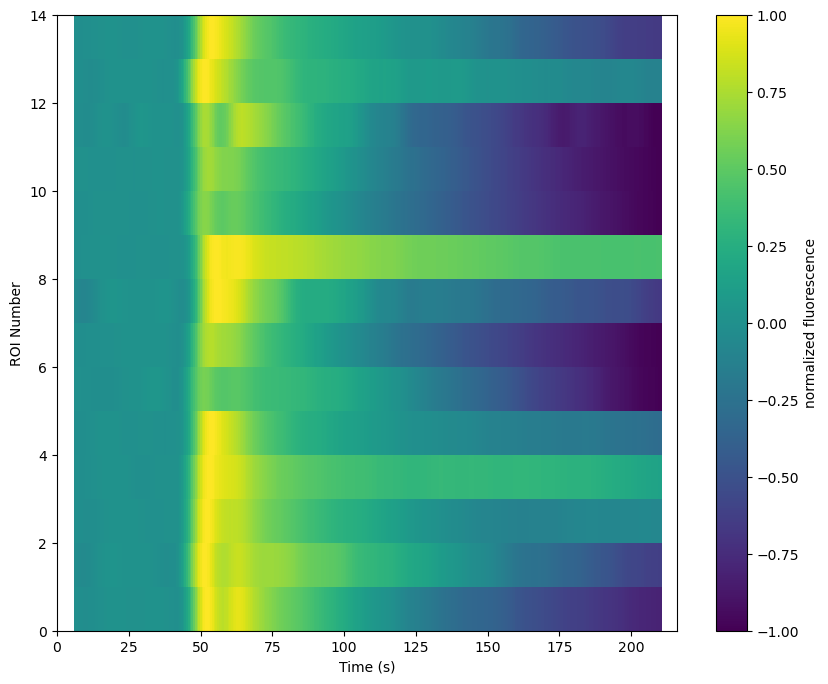

In [33]:

    if frames_to_seconds:
        mesh_df= normalized_df.copy()
        mesh_df.reset_index(drop=True, inplace=True)
        new_index=list(mesh_df.index)
        new_index.append(len(list(mesh_df.index)))
        new_index=pd.Series(new_index)/fps_rate
        new_columns=pd.Series(list(range(0, len(mesh_df.columns)+1)))

        fig, ax0 = plt.subplots(figsize=(10,8))
        im = ax0.pcolormesh(new_index,new_columns, (mesh_df.transpose()))
        fig.colorbar(im, ax=ax0, label='normalized fluorescence')
        ax0.set_xlabel('Time (s)')
        ax0.set_ylabel('ROI Number')   
        if save_images:
            plt.savefig((path_to_save_date + '_heatmap.svg'), format='svg', dpi=300)
        plt.show()


    else:
        fig, ax0 = plt.subplots(figsize=(10,8))
        im = ax0.pcolormesh((normalized_df.transpose()))
        fig.colorbar(im, ax=ax0, label='\u0394 F/F')

        ax0.set_xlabel('Frame')
        ax0.set_ylabel('ROI Number')

        ax0.axvline(x=start_wash_in_1, color='k', ls='dashed', alpha=0.75)
        ax0.axvline(x=start_wash_in_2, color='k', ls='dashed', alpha=0.75)
        if save_images:
            plt.savefig((path_to_save_date + '_heatmap.svg'), format='svg', dpi=300)   
        plt.show()

Now you can save the data as an excel file and do more analysis yourself.

In [33]:
save_path='/Users/lutz/Documents/imaing analysis/'
name='processed_data.xlsx'
normalized_df.to_excel(save_path+name)